# 11. Collaborative Filtering - Deep Learning
## Neural Collaborative Filtering

In [1]:
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import OneHotEncoder
import scipy as sp
from sklearn.model_selection import train_test_split
from keras.layers import Embedding, Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.models import Sequential, Model
from tensorflow.sparse import SparseTensor
import keras
from keras import layers
from keras import ops
import tensorflow as tf


In [2]:
%run "6.Recommendations_Sample.ipynb"

Number of users 5,000
First five users id [ 9880850 11308871 10339131  8414394  9734353]


C:\Users\riccardoricci\AppData\Local\Temp\ipykernel_2952\3332260560.py:3: DeprecationWarning: Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
  data = pickle.load(f)


Number of Rows: 12,663,134
Numbeer of Columns: 37,420
Number of stored values: 47,967,516
Number of Rows: 4,916
Numbeer of Columns: 37,420
Number of stored values: 191,000
Number of Rows: 4,917
Numbeer of Columns: 17,109
Number of stored values: 208,108


In [3]:
recommendations_sample.head()

,app_id,helpful,funny,date,is_recommended,hours,user_id,review_id,user_id_categorical,app_id_categorical
38408207,238010,0,0,2019-12-01,1,39.0,12039,38408207,10783,1742
40762148,1782210,0,0,2021-12-14,1,5.0,12039,40762148,10783,33450
13596940,453480,12,6,2022-02-13,1,5.4,12039,13596940,10783,7783
5429077,381210,0,0,2021-10-20,1,10.0,12039,5429077,10783,5720
40340451,420110,4,2,2016-06-16,1,6.0,12039,40340451,10783,6843


In [4]:
user_game_matrix_k_rec.todense()

matrix([[       0,        1,        2, ...,    37399,    37401,    37414],
        [   10783,        0,        0, ...,        0,        0,        0],
        [   11762,        0,        0, ...,        0,        0,        0],
        ...,
        [12659873,        0,        0, ...,        0,        0,        0],
        [12660359,        0,        0, ...,        0,        0,        0],
        [12662371,        0,        0, ...,        0,        0,        0]],
       dtype=int32)

## Train Test Split

### Test Set

In [5]:
# def get_test_instances(test):
def get_test_instances(df):
    """
    This functions generates test instances using the Leave One Out Approach taking the maximum recommendation date
    """
    max_df = df.groupby("user_id_categorical").agg({"date": np.nanmax}).reset_index()
    rec_df = pd.merge(df, max_df, left_on=["user_id_categorical","date"], right_on=["user_id_categorical","date"])
    rec_df["user_id_categorical_new"] = rec_df["user_id_categorical"].map(swapped_users_dict)
    rec_df["app_id_categorical_new"] = rec_df["app_id_categorical"].map(swapped_games_dict)
    x_test = rec_df[["user_id_categorical_new", "app_id_categorical_new"]].values
    y_test = np.full((x_test.shape[0],1), 1)
    return x_test, y_test

x_test, y_test = get_test_instances(recommendations_sample)
print("x_test.shape",  x_test.shape)
print("y_test.shape",  y_test.shape)


C:\Users\riccardoricci\AppData\Local\Temp\ipykernel_2952\3121204030.py:6: FutureWarning: The provided callable <function nanmax at 0x000002053A94DAF0> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  max_df = df.groupby("user_id_categorical").agg({"date": np.nanmax}).reset_index()


x_test.shape (6533, 2)
y_test.shape (6533, 1)


In [6]:
x_test_dict = dict(x_test)

### Get Training Istances

Including negative samples

In [7]:
train = user_game_matrix_k_rec[1:,1:].todok()
num_users, num_items = train.shape
print("Number of Users:", '{0:,.0f}'.format(num_users))
print("Number of Games:", '{0:,.0f}'.format(num_items))


Number of Users: 4,916
Number of Games: 17,108


In [8]:
def get_train_instances(train, num_negatives):
    """
    This function generates training instances. For each user in the training data,
    I should have users who recommended games and users who do not recommend games
    """
    user_input, item_input, labels = [],[],[]
    for (u, i) in train.keys():
        # positive instance
        user_input.append(u)
        item_input.append(i)
        labels.append(1)
        # negative instances
        item_selected = [] # to avoid duplicates
        for t in range(num_negatives):
            j = np.random.randint(num_items)
            while ((u, j) in train.keys()) or ((u,j) in item_selected) or ((u,j) in x_test_dict.keys()):
                j = np.random.randint(num_items)
               # print("user:", u)
               #  print("game:", j)
            user_input.append(u)
            item_input.append(j)
            labels.append(0)
            item_selected.append((u,j))
        
    p = np.vstack([user_input, item_input, labels]).T
    p = np.unique(p, axis=0)
    x_train = p[:,:2]
    y_train = p[:, 2].reshape(-1, 1) # np.array(labels).reshape(1,-1).T
    return x_train, y_train

x_train, y_train = get_train_instances(train, 4)
print("x_train.shape",  x_train.shape)
print("y_train.shape",  x_train.shape)


x_train.shape (924063, 2)
y_train.shape (924063, 2)


## Create the model

In [9]:
# EMBEDDING_SIZE = 50

class RecommenderNet(keras.Model):
    # def __init__(self, num_users, num_items, embedding_size, num_units_layers=[64,32],  **kwargs):
    def __init__(self, num_users, num_items, num_units_layers,  **kwargs):
        super().__init__(**kwargs)
        self.num_users = num_users
        self.num_items = num_items
        # embeddings reduce the dimensionality, they are like look up tables
        # self.embedding_size = embedding_size
        self.user_input = Input(shape=(1,), dtype='int32', name = 'user_input')
        self.item_input = Input(shape=(1,), dtype='int32', name = 'item_input')
        self.user_embedding = layers.Embedding(
            input_dim=num_users,
            output_dim= int(num_units_layers[0]/2), # embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        # self.user_bias = layers.Embedding(num_users, 1)
        
        self.game_embedding = layers.Embedding(
            input_dim=num_items,
            output_dim= int(num_units_layers[0]/2), # embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        # self.game_bias = layers.Embedding(num_items, 1)

        # 
        self.flatten_users = layers.Flatten()
        self.flatten_games = layers.Flatten()
        self.concat_users_games = layers.Concatenate()
        self.dense_layer_1 = layers.Dense(
            units = num_units_layers[0],
            activation = "relu",
            kernel_initializer="glorot_uniform"
        )
        self.dense_layer_2 = layers.Dense(
            units = num_units_layers[1],
            activation = "relu",
            kernel_initializer="glorot_uniform"
        )
        self.prediction = layers.Dense(
            units = 1,
            activation = "sigmoid",
            input_dim = num_units_layers[1]
        )


    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:,0])
        # user_bias = self.user_bias(inputs[:,0])
        game_vector = self.game_embedding(inputs[:,1])
        # game_bias = self.game_bias(inputs[:,1])
        # dot_user_game = ops.tensordot(user_vector, game_vector, 2)
        # x = dot_user_game + user_bias + game_bias
        users_flat = self.flatten_users(user_vector)
        # print(users_flat.shape)
        games_flat = self.flatten_games(game_vector)
        concat = self.concat_users_games([users_flat, games_flat])
        dense_layer_1 = self.dense_layer_1(concat)
        dense_layer_2 = self.dense_layer_2(dense_layer_1)
        prediction = self.prediction(dense_layer_2)
        # return ops.nn.softmax(prediction)    
        # return ops.nn.sigmoid(x)
        return prediction # ops.nn.sigmoid(prediction)


# model = RecommenderNet(num_users, num_items, EMBEDDING_SIZE)
model = RecommenderNet(num_users, num_items, [20,10])
model.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001), # Adagrad is suited for sparse data
    # metrics=['accuracy']
)

c:\Users\riccardoricci\.conda\envs\NCF\lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
# https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit
history = model.fit(
    x=x_train, # user_idx and app_idx
    y=y_train, # recommendations, always 1
    #batch_size=64, # Number of samples per gradient update aka Minibatch Gradient Descent
    epochs=10, # Number of epochs to train the model. An epoch is an iteration over the entire x and y data provided
    verbose=1, # progress line
    validation_data=(x_test, y_test) # Data on which to evaluate the loss and any model metrics at the end of each epoch
    
)

Epoch 1/10
28877/28877 ━━━━━━━━━━━━━━━━━━━━ 34s 1ms/step - loss: 0.3594 - val_loss: 0.9571
Epoch 2/10
28877/28877 ━━━━━━━━━━━━━━━━━━━━ 33s 1ms/step - loss: 0.3171 - val_loss: 1.0214
Epoch 3/10
28877/28877 ━━━━━━━━━━━━━━━━━━━━ 34s 1ms/step - loss: 0.3132 - val_loss: 0.9687
Epoch 4/10
28877/28877 ━━━━━━━━━━━━━━━━━━━━ 34s 1ms/step - loss: 0.3109 - val_loss: 0.9493
Epoch 5/10
28877/28877 ━━━━━━━━━━━━━━━━━━━━ 33s 1ms/step - loss: 0.3069 - val_loss: 0.9086
Epoch 6/10
28877/28877 ━━━━━━━━━━━━━━━━━━━━ 33s 1ms/step - loss: 0.3069 - val_loss: 0.9357
Epoch 7/10
28877/28877 ━━━━━━━━━━━━━━━━━━━━ 34s 1ms/step - loss: 0.3051 - val_loss: 0.9030
Epoch 8/10
28877/28877 ━━━━━━━━━━━━━━━━━━━━ 34s 1ms/step - loss: 0.3050 - val_loss: 0.9340
Epoch 9/10
28877/28877 ━━━━━━━━━━━━━━━━━━━━ 33s 1ms/step - loss: 0.3025 - val_loss: 0.7947
Epoch 10/10
28877/28877 ━━━━━━━━━━━━━━━━━━━━ 34s 1ms/step - loss: 0.3015 - val_loss: 0.8578


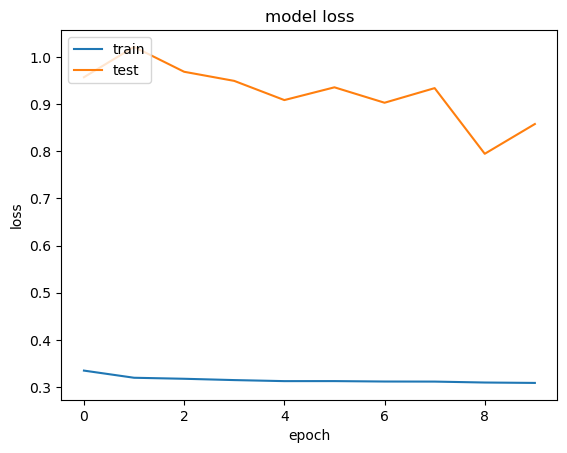

In [11]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

## Model Evaluation

In [12]:
x_train

array([[    0,    20],
       [    0,   279],
       [    0,   297],
       ...,
       [ 4915, 16815],
       [ 4915, 16967],
       [ 4915, 17057]])

In [13]:
y_train

array([[1],
       [1],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [14]:
x_test

array([[    0, 12246],
       [    1, 11826],
       [    2, 15161],
       ...,
       [ 4913,  2208],
       [ 4914,  9434],
       [ 4915, 12246]], dtype=int64)

In [15]:
y_test

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]])

In [16]:
num_users, num_games = train.shape

In [17]:
%run "Model_Evaluation.ipynb"

In [18]:
K = 30 ### CHOOSE K FOR TOP-K ACCURACY
n_users2val = 10 ### CHOOSE THE NUMBER OF USERS YOU WANT TO EVALUATE

In [19]:
prec, rec = eval_k_avg(n_users2val, K, num_users, num_games, x_train, y_train)
print("Number of users:", n_users2val)
print("K:",K)
print("Average Precision", '{0:.4%}'.format(prec))
print("Average Recall", '{0:.4%}'.format(rec))


535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 615us/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 624us/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
Number of users: 10
K: 30
Average Precision 5.0000%
Average Recall 5.9539%


In [20]:
hit_r = eval_hit_ratio(n_users2val, K, num_games, x_test)
print("Number of users:", n_users2val)
print("K:",K)
print("Hit Ratio:", '{0:.4%}'.format(hit_r))

535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 848us/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 658us/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step
Number of users: 10
K: 30
Hit Ratio: 20.0000%
